## Chempy
we will now introduce the Chempy function which will calculate the chemical evolution of a one-zone open box model

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ../source/

/home/jan/Arbeitsfläche/Chempy_git/source


In [3]:
from parameter import ModelParameters
a = ModelParameters()

## Loading all the input
- solar abundances
- SFR
- infall
- initial abundances and inflowing abundances

In [4]:
from wrapper import initialise_stuff
basic_solar, basic_sfr, basic_infall = initialise_stuff(a)
elements_to_trace = a.elements_to_trace

## Elemental abundances at start
We need to define the abundances of:
- The ISM at beginning
- The corona gas at beginning
- The cosmic inflow into the corona for all times.
For all we chose primordial here.

In [5]:
from infall import INFALL, PRIMORDIAL_INFALL
basic_primordial = PRIMORDIAL_INFALL(list(elements_to_trace),np.copy(basic_solar.table))
basic_primordial.primordial(0)
basic_primordial.fractions

array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.76,  0.24,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ])

## Initialising the element evolution matrix
We now feed everything into the abundance matrix and check its entries

In [6]:
from time_integration import ABUNDANCE_MATRIX
cube = ABUNDANCE_MATRIX(np.copy(basic_sfr.t),np.copy(basic_sfr.sfr),np.copy(basic_infall.infall),list(elements_to_trace),list(basic_primordial.symbols),list(basic_primordial.fractions),float(a.gas_at_start),list(basic_primordial.symbols),list(basic_primordial.fractions),float(a.gas_reservoir_mass_factor),float(a.outflow_feedback_fraction),bool(a.check_processes),float(a.starformation_efficiency),float(a.gas_power), float(a.sfr_factor_for_cosmic_accretion), list(basic_primordial.symbols), list(basic_primordial.fractions))
print list(cube.cube.dtype.names)
print cube.cube['He']

['sfr', 'infall', 'time', 'feedback', 'mass_in_remnants', 'stars', 'gas', 'Z', 'alpha', 'sn1a', 'sn2', 'pn', 'bh', 'hn', 'Al', 'Ar', 'B', 'Be', 'C', 'Ca', 'Cl', 'Co', 'Cr', 'Cu', 'F', 'Fe', 'Ga', 'Ge', 'H', 'He', 'K', 'Li', 'Mg', 'Mn', 'N', 'Na', 'Ne', 'Ni', 'O', 'P', 'S', 'Sc', 'Si', 'Ti', 'V', 'Zn']
[  9.26869415e-05   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]


## Time integration
With the advance_one_step method we can evolve the matrix in time, given that we provide the feedback from each steps previous SSP.

In [7]:
from wrapper import SSP_wrap
basic_ssp = SSP_wrap(a)
for i in range(len(basic_sfr.t)-1):
    j = len(basic_sfr.t)-i
    element_fractions = []
    for item in elements_to_trace:
        element_fractions.append(float(np.copy(cube.cube[item][max(i-1,0)]/cube.cube['gas'][max(i-1,0)])))## gas element fractions from one time step before	
    metallicity = float(cube.cube['Z'][i])
    time_steps = np.copy(basic_sfr.t[:j])
    basic_ssp.calculate_feedback(float(metallicity), list(elements_to_trace), list(element_fractions), np.copy(time_steps))
    cube.advance_one_step(i+1,np.copy(basic_ssp.table),np.copy(basic_ssp.sn2_table),np.copy(basic_ssp.agb_table),np.copy(basic_ssp.sn1a_table))
print cube.cube['He']

[  9.26869415e-05   1.40860453e-02   2.46201078e-02   3.22716659e-02
   3.75769269e-02   4.09880689e-02   4.28975911e-02   4.36286864e-02
   4.34475615e-02   4.25757031e-02   4.11957803e-02   3.94498921e-02
   3.74567135e-02   3.53087975e-02   3.30824748e-02   3.08305729e-02
   2.86006517e-02   2.64208026e-02   2.43259121e-02   2.23255178e-02
   2.04333626e-02   1.86576398e-02   1.69950788e-02   1.54481327e-02
   1.40162342e-02   1.26941237e-02   1.14762096e-02   1.03656268e-02]


## Making abundances from element fractions
The cube stores everything in elemental fractions, we use a tool to convert these to abundances scaled to solar:

In [8]:
from making_abundances import mass_fraction_to_abundances
abundances,elements,numbers = mass_fraction_to_abundances(np.copy(cube.cube),np.copy(basic_solar.table))
print abundances['He']

[-0.02951008 -0.02944417 -0.02371412 -0.01804385 -0.01281405 -0.00807708
 -0.0036858   0.00039861  0.00418825  0.00773171  0.0110975   0.01425566
  0.01724532  0.02006999  0.02279457  0.02534465  0.02780392  0.03007043
  0.03243048  0.03472625  0.03703849  0.0394542   0.04178142  0.04408782
  0.04643867  0.04874673  0.05094251  0.05349851]


making_abundances.py:34: RuntimeWarning: divide by zero encountered in log10
  cube_abundances[item] = np.log10(cube_abundances[item]) + 12.


/home/jan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in subtract
  if __name__ == '__main__':


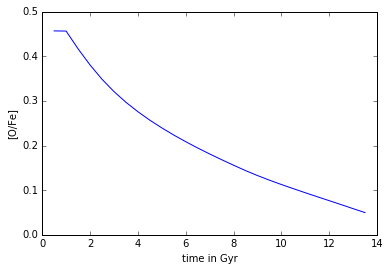

In [9]:
plot(cube.cube['time'],abundances['O']-abundances['Fe'])
plt.xlabel('time in Gyr')
plt.ylabel('[O/Fe]')

/home/jan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in subtract
  if __name__ == '__main__':
/home/jan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in subtract
  from ipykernel import kernelapp as app
/home/jan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in subtract
  app.launch_new_instance()


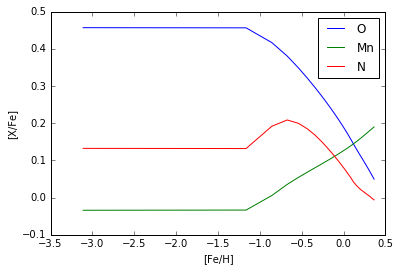

In [10]:
plot(abundances['Fe'],abundances['O']-abundances['Fe'], label = 'O')
plot(abundances['Fe'],abundances['Mn']-abundances['Fe'], label = 'Mn')
plot(abundances['Fe'],abundances['N']-abundances['Fe'], label = 'N')
plt.xlabel('[Fe/H]')
plt.ylabel('[X/Fe]')
plt.legend()

## Likelihood calculation
There are a few build-in functions (actually representing the observational constraints from the Chempy paper) which return a likelihood. One of those is called sol_norm and compares the proto-solar abundances with the Chempy ISM abundances 4.5 Gyr ago.

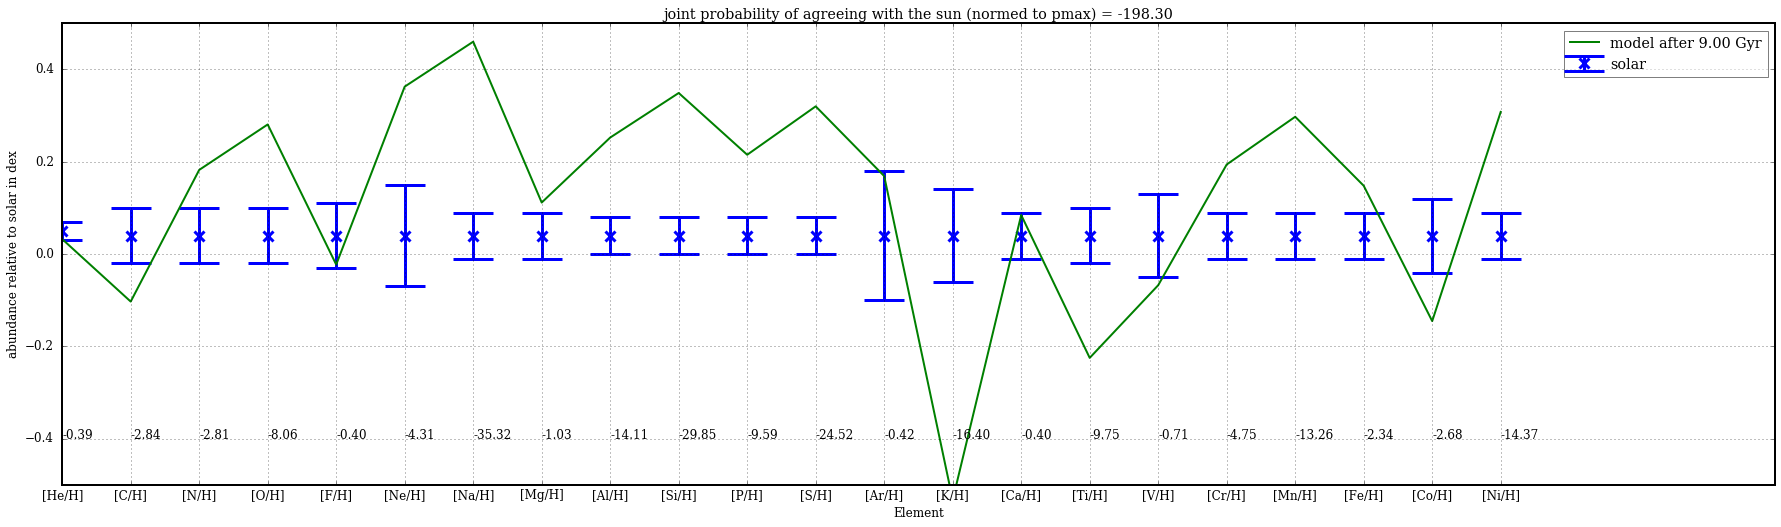

In [11]:
from data_to_test import sol_norm
probabilities, abundance_list, element_names = sol_norm(True,a.name_string,np.copy(abundances),np.copy(cube.cube),elements_to_trace,a.element_names,np.copy(basic_solar.table),a.number_of_models_overplotted,a.produce_mock_data,a.use_mock_data,a.error_inflation)

## Net vs. Gross yields
Now we will change a little detail in the time-integration. Instead of letting unprocessed material that is expelled from the stars ('unprocessed_mass_in_winds' in the yield tables) being composed of the stellar birth material, which would be consistent (and is what I call 'net' yield), we now use solar-scaled material which only has the same metallicity as the stellar birth material (This is what happens if yield tables are giving the total 'gross' yield including the unprocessed material, which means that the author usually uses solar-scaled material which is then expelled by the star, but might not even be produced by it). Therefore we see a difference in the likelihood which is better for the gross yields case (-180.05 vs -198.30). We see the difference especially well in K and Ti.

/home/jan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


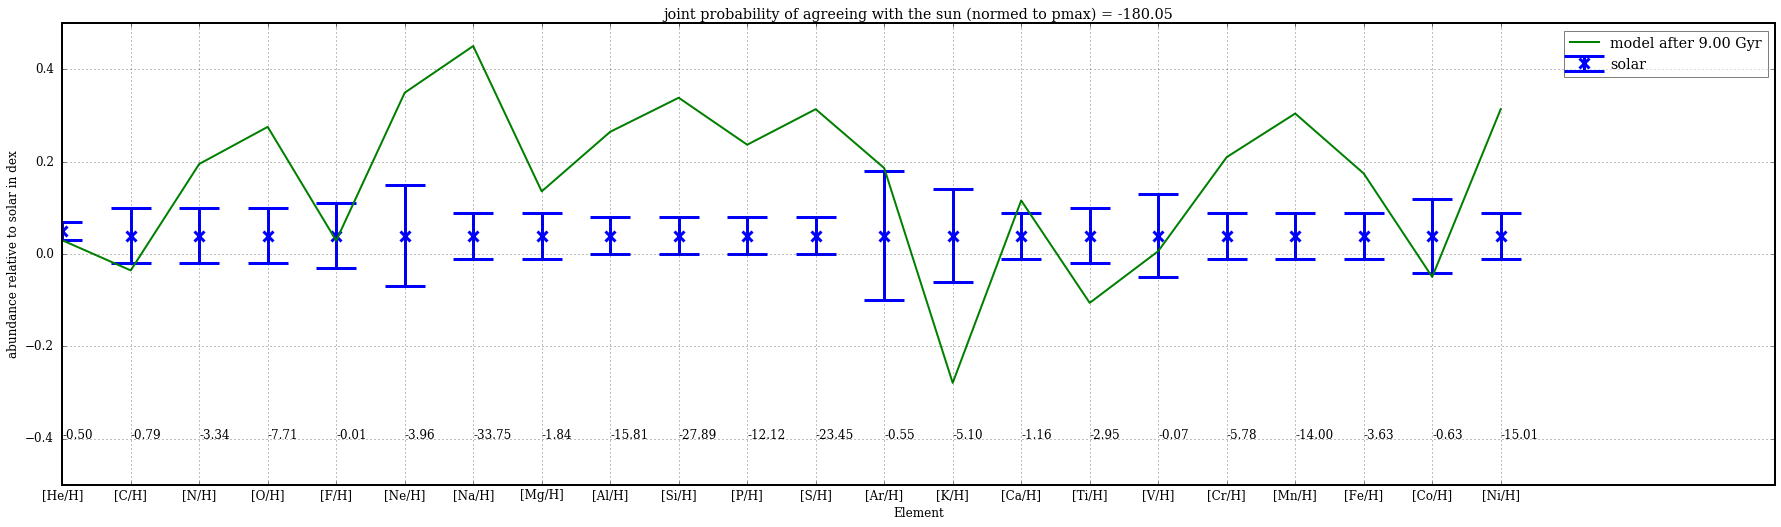

In [12]:
cube = ABUNDANCE_MATRIX(np.copy(basic_sfr.t),np.copy(basic_sfr.sfr),np.copy(basic_infall.infall),list(elements_to_trace),list(basic_primordial.symbols),list(basic_primordial.fractions),float(a.gas_at_start),list(basic_primordial.symbols),list(basic_primordial.fractions),float(a.gas_reservoir_mass_factor),float(a.outflow_feedback_fraction),bool(a.check_processes),float(a.starformation_efficiency),float(a.gas_power), float(a.sfr_factor_for_cosmic_accretion), list(basic_primordial.symbols), list(basic_primordial.fractions))
basic_ssp = SSP_wrap(a)
for i in range(len(basic_sfr.t)-1):
    j = len(basic_sfr.t)-i
    metallicity = float(cube.cube['Z'][i])
    solar_scaled_material = PRIMORDIAL_INFALL(list(elements_to_trace),np.copy(basic_solar.table))
    solar_scaled_material.solar(np.log10(metallicity/basic_solar.z))
    time_steps = np.copy(basic_sfr.t[:j])
    basic_ssp.calculate_feedback(float(metallicity), list(elements_to_trace), list(solar_scaled_material.fractions), np.copy(time_steps))
    cube.advance_one_step(i+1,np.copy(basic_ssp.table),np.copy(basic_ssp.sn2_table),np.copy(basic_ssp.agb_table),np.copy(basic_ssp.sn1a_table))
abundances,elements,numbers = mass_fraction_to_abundances(np.copy(cube.cube),np.copy(basic_solar.table))
probabilities, abundance_list, element_names = sol_norm(True,a.name_string,np.copy(abundances),np.copy(cube.cube),elements_to_trace,a.element_names,np.copy(basic_solar.table),a.number_of_models_overplotted,a.produce_mock_data,a.use_mock_data,a.error_inflation)

## Making chemical evolution modelling fast and flexible
Now we have all ingredients at hand. We use a wrapper function were we only need to pass the ModelParameters.

/home/jan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in subtract
/home/jan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in subtract
/home/jan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in subtract


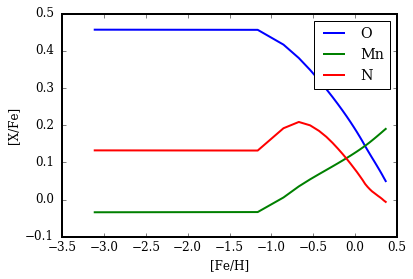

In [13]:
from wrapper import Chempy
a = ModelParameters()
cube, abundances, gas_reservoir = Chempy(a)
plot(abundances['Fe'],abundances['O']-abundances['Fe'], label = 'O')
plot(abundances['Fe'],abundances['Mn']-abundances['Fe'], label = 'Mn')
plot(abundances['Fe'],abundances['N']-abundances['Fe'], label = 'N')
plt.xlabel('[Fe/H]')
plt.ylabel('[X/Fe]')
plt.legend()

## IMF effect
now we can easily check the effect of the IMF on the chemical evolution

/home/jan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in subtract
/home/jan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in subtract
/home/jan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in subtract
/home/jan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in subtract
/home/jan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in subtract
/home/jan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in subtract
/home/jan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in subtract
/home/jan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value enc

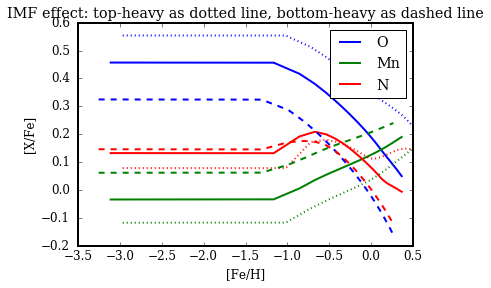

In [14]:
a = ModelParameters()
a.imf_parameter= (22.8978, 716.4, 0.25,-2.29)
cube, abundances, gas_reservoir = Chempy(a)

plot(abundances['Fe'],abundances['O']-abundances['Fe'], label = 'O')
plot(abundances['Fe'],abundances['Mn']-abundances['Fe'], label = 'Mn')
plot(abundances['Fe'],abundances['N']-abundances['Fe'], label = 'N')


a = ModelParameters()
a.imf_parameter = (22.8978, 716.4, 0.25,-2.09)
cube, abundances, gas_reservoir = Chempy(a)

plot(abundances['Fe'],abundances['O']-abundances['Fe'], color = 'b', linestyle = ':')
plot(abundances['Fe'],abundances['Mn']-abundances['Fe'], color = 'g', linestyle = ':')
plot(abundances['Fe'],abundances['N']-abundances['Fe'], color = 'r', linestyle = ':')

a = ModelParameters()
a.imf_parameter = (22.8978, 716.4, 0.25,-2.49)
cube, abundances, gas_reservoir = Chempy(a)

plot(abundances['Fe'],abundances['O']-abundances['Fe'], color = 'b', linestyle = '--')
plot(abundances['Fe'],abundances['Mn']-abundances['Fe'], color = 'g', linestyle = '--')
plot(abundances['Fe'],abundances['N']-abundances['Fe'], color = 'r', linestyle = '--')


plt.xlabel('[Fe/H]')
plt.ylabel('[X/Fe]')
plt.title('IMF effect: top-heavy as dotted line, bottom-heavy as dashed line')
plt.legend()

## SFR effect
We can do the same for the peak of the SFR etc...

/home/jan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in subtract
/home/jan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in subtract
/home/jan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in subtract
/home/jan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in subtract
/home/jan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in subtract
/home/jan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in subtract
/home/jan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in subtract
/home/jan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value enc

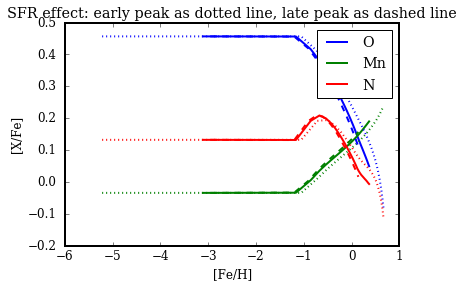

In [15]:
a = ModelParameters()
a.sfr_scale = 3.5
cube, abundances, gas_reservoir = Chempy(a)

plot(abundances['Fe'],abundances['O']-abundances['Fe'], label = 'O')
plot(abundances['Fe'],abundances['Mn']-abundances['Fe'], label = 'Mn')
plot(abundances['Fe'],abundances['N']-abundances['Fe'], label = 'N')


a = ModelParameters()
a.sfr_scale = 1.5
cube, abundances, gas_reservoir = Chempy(a)

plot(abundances['Fe'],abundances['O']-abundances['Fe'], color = 'b', linestyle = ':')
plot(abundances['Fe'],abundances['Mn']-abundances['Fe'], color = 'g', linestyle = ':')
plot(abundances['Fe'],abundances['N']-abundances['Fe'], color = 'r', linestyle = ':')

a = ModelParameters()
a.sfr_scale = 6.5
cube, abundances, gas_reservoir = Chempy(a)

plot(abundances['Fe'],abundances['O']-abundances['Fe'], color = 'b', linestyle = '--')
plot(abundances['Fe'],abundances['Mn']-abundances['Fe'], color = 'g', linestyle = '--')
plot(abundances['Fe'],abundances['N']-abundances['Fe'], color = 'r', linestyle = '--')


plt.xlabel('[Fe/H]')
plt.ylabel('[X/Fe]')
plt.title('SFR effect: early peak as dotted line, late peak as dashed line')
plt.legend()

## A note on chemical evolution tracks and 'by eye' fit
Sometimes Astronomers like to show that their chemical evolution track runs through some stellar abundance data points. But if we want the computer to steer our result fit we need to know the selection function of the stars that we try to match and we need to take our star formation history into account (Maybe there are almost no stars formed after 8Gyr).